<a href="https://colab.research.google.com/github/R12942159/NTU_DLCV/blob/Hw1/DLCV_hw1_p1_EFFICIENTNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch


# Get cuda from GPU device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


In [ ]:
import os


# search file paths
def img_paths(path):
  paths = [os.path.join(path, i) for i in os.listdir(path) if i.endswith('.png')]
  return paths

img_paths_train = img_paths('/content/drive/MyDrive/NTU_DLCV/p1_data/train_50')
img_paths_val = img_paths('/content/drive/MyDrive/NTU_DLCV/p1_data/val_50')

In [ ]:
img_paths_train = img_paths('/content/drive/MyDrive/NTU_DLCV/p1_data/train_50')
img_paths_val = img_paths('/content/drive/MyDrive/NTU_DLCV/p1_data/val_50')

In [ ]:
# number of images
len(img_paths_train), len(img_paths_val)

(22500, 2500)

In [ ]:
import torch
from PIL import Image
import numpy as np


class PretrainDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        """number of samples"""
        return len(self.img_paths)

    def __getitem__(self, idx):
        """read 1 sample"""
        # Read img
        path = self.img_paths[idx] # get img path
        img = Image.open(path).convert('RGB') # read img

        # transform img
        img = self.transform(img)

        # Read class index
        cls_idx = int((path.split('/')[-1]).split('_')[0])
        cls_idx = torch.tensor(cls_idx, dtype=torch.int64)

        return img, cls_idx

In [ ]:
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights


# Preprocess Transform
transform =  EfficientNet_B4_Weights.DEFAULT.transforms()

# Build Dataset
train_ds = PretrainDataset(img_paths_train, transform)
val_ds = PretrainDataset(img_paths_val, transform)

In [ ]:
transform

ImageClassification(
    crop_size=[380]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Build DataLoaders
BATCH_SIZE = 50
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

#### Build Model (https://pytorch.org/vision/stable/models.html#classification)

In [ ]:
from torchvision import models

model = models.efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
print(model)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:01<00:00, 70.6MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
# 获取最后一层线性层的子模块列表
last_layer = list(model.children())[-1]

# 获取线性层中的权重和偏差
weights = last_layer[1].weight
bias = last_layer[1].bias

# 创建一个新的线性层，将out_features设置为50
new_linear_layer = torch.nn.Linear(in_features=weights.shape[1], out_features=50, bias=True)

# 将新的线性层的权重和偏差设置为旧线性层的权重和偏差
new_linear_layer.weight.data = weights
new_linear_layer.bias.data = bias

# 将新的线性层替换为模型的最后一层
last_layer[1] = new_linear_layer

In [ ]:
from torchsummary import summary


resize_size = transform.resize_size[0]
summary(model.to(device), (3, resize_size, resize_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 192, 192]           1,296
       BatchNorm2d-2         [-1, 48, 192, 192]              96
              SiLU-3         [-1, 48, 192, 192]               0
            Conv2d-4         [-1, 48, 192, 192]             432
       BatchNorm2d-5         [-1, 48, 192, 192]              96
              SiLU-6         [-1, 48, 192, 192]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12         [-1, 48, 192, 192]               0
           Conv2d-13         [-1, 24, 192, 192]           1,152
      BatchNorm2d-14         [-1, 24, 1

#### Train Model

In [ ]:
from tqdm.auto import tqdm # (optional) progress bar


def training(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode. (The Dropout layer has a different behavior between the training mode and the evaluation mode.)
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def testing(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [ ]:
import matplotlib.pyplot as plt
from torch import nn
import numpy as np


def train(pretrained=True, freeze=False):
    print(f"pretrained weights: {pretrained}, freeze: {freeze}")
    # Model
    if pretrained:
        model = models.efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
    else:
        model = models.efficientnet_b4(weights=None)

    if freeze:
        # Freeze model
        for param in model.parameters():
            param.requires_grad = False

    # Replace classifier
    last_layer = list(model.children())[-1]
    weights = last_layer[1].weight
    bias = last_layer[1].bias
    new_linear_layer = torch.nn.Linear(in_features=weights.shape[1], out_features=50, bias=True)
    new_linear_layer.weight.data = weights
    new_linear_layer.bias.data = bias
    last_layer[1] = new_linear_layer

    model = model.to(device)

    # set the loss func.
    loss_fn = nn.CrossEntropyLoss()
    # lower learning rate for finetuning
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=1e-4)


    EPOCHS = 20
    logs = {
        'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
    }
    for epoch in tqdm(range(EPOCHS)):
        train_loss, train_acc = training(train_loader, model, loss_fn, optimizer)
        val_loss, val_acc = testing(val_loader, model, loss_fn)

        # # Note that step should be called after test_epoch()
        # schedule.step(val_loss)

        print(f'EPOCH: {epoch:04d} \
        train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
        val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

        logs['train_loss'].append(train_loss)
        logs['train_acc'].append(train_acc)
        logs['val_loss'].append(val_loss)
        logs['val_acc'].append(val_acc)


    # plot result
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(logs['train_loss'])
    plt.plot(logs['val_loss'])
    plt.savefig(os.path.join("/content/drive/MyDrive/NTU_DLCV/p1_data/EFFICIENTNET result/Loss_epoch20"), format='png')

    plt.subplot(1, 2, 2)
    plt.title('Acc.')
    plt.plot(logs['train_acc'])
    plt.plot(logs['val_acc'])
    plt.savefig(os.path.join("/content/drive/MyDrive/NTU_DLCV/p1_data/EFFICIENTNET result/Acc_epoch20"), format='png')

    # Save model
    torch.save(optimizer.state_dict(), "/content/drive/MyDrive/NTU_DLCV/p1_data/EFFICIENTNET result/EFFICIENTNET_best_optimizer.pth")
    torch.save(model.state_dict(), "/content/drive/MyDrive/NTU_DLCV/p1_data/EFFICIENTNET result/EFFICIENTNET_best_model.pth")

#### Transfer Learning

pretrained weights: True, freeze: False


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0000         train_loss: 3.5769, train_acc: 0.211         val_loss: 1.3902, val_acc: 0.618 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0001         train_loss: 1.1579, train_acc: 0.674         val_loss: 0.6676, val_acc: 0.798 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0002         train_loss: 0.6672, train_acc: 0.801         val_loss: 0.5273, val_acc: 0.840 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0003         train_loss: 0.4633, train_acc: 0.857         val_loss: 0.4779, val_acc: 0.858 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0004         train_loss: 0.3480, train_acc: 0.891         val_loss: 0.4504, val_acc: 0.870 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0005         train_loss: 0.2600, train_acc: 0.917         val_loss: 0.4412, val_acc: 0.878 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0006         train_loss: 0.2018, train_acc: 0.935         val_loss: 0.4364, val_acc: 0.879 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0007         train_loss: 0.1655, train_acc: 0.946         val_loss: 0.4612, val_acc: 0.878 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0008         train_loss: 0.1251, train_acc: 0.960         val_loss: 0.4644, val_acc: 0.882 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0009         train_loss: 0.1044, train_acc: 0.965         val_loss: 0.4863, val_acc: 0.884 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0010         train_loss: 0.0840, train_acc: 0.973         val_loss: 0.5232, val_acc: 0.883 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0011         train_loss: 0.0737, train_acc: 0.977         val_loss: 0.4904, val_acc: 0.888 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0012         train_loss: 0.0707, train_acc: 0.978         val_loss: 0.4922, val_acc: 0.890 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0013         train_loss: 0.0566, train_acc: 0.982         val_loss: 0.5332, val_acc: 0.887 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0014         train_loss: 0.0492, train_acc: 0.984         val_loss: 0.5100, val_acc: 0.892 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0015         train_loss: 0.0447, train_acc: 0.987         val_loss: 0.5378, val_acc: 0.892 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0016         train_loss: 0.0408, train_acc: 0.987         val_loss: 0.5473, val_acc: 0.892 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0017         train_loss: 0.0381, train_acc: 0.988         val_loss: 0.5587, val_acc: 0.888 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0018         train_loss: 0.0330, train_acc: 0.989         val_loss: 0.5656, val_acc: 0.888 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0019         train_loss: 0.0323, train_acc: 0.990         val_loss: 0.5413, val_acc: 0.891 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0020         train_loss: 0.0290, train_acc: 0.991         val_loss: 0.5627, val_acc: 0.887 


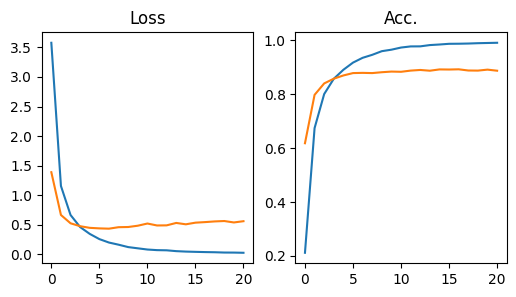

In [ ]:
train()

In [ ]:
# Build Model and Replace classifier
from torchvision import models


model = models.efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)

last_layer = list(model.children())[-1]
weights = last_layer[1].weight
bias = last_layer[1].bias
new_linear_layer = torch.nn.Linear(in_features=weights.shape[1], out_features=50, bias=True)
new_linear_layer.weight.data = weights
new_linear_layer.bias.data = bias
last_layer[1] = new_linear_layer

model.load_state_dict(torch.load("/content/drive/MyDrive/NTU_DLCV/p1_data/EFFICIENTNET result/EFFICIENTNET_best_model.pth"))

model = model.to(device) # move model to GPU
model.eval() # Set model to evaluation mode

# Create temp tensor
y_true = torch.tensor([], dtype=torch.long).to(device)
y_pred_logits = torch.tensor([]).to(device)

from torch import nn


# deactivate autograd engine and reduce memory usage and speed up computations
with torch.no_grad():
    for batch_i, (x, y) in enumerate(val_loader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        # Concatenate Ground truth and prediction
        y_true = torch.cat((y_true, y), dim=0)
        y_pred_logits = torch.cat((y_pred_logits, pred), dim=0)

y_pred_cls = y_pred_logits.argmax(1) # get class idx with max prob (100, 3) -> (100, )

# Move tensor to CPU and convert to np.ndarray
y_true = y_true.cpu().numpy()
y_pred_cls = y_pred_cls.cpu().numpy()

print(y_true, y_pred_cls, sep = '\n')

[ 9 43  3 ... 25 31 30]
[ 9 43  3 ... 25 31 30]


In [ ]:
import csv
import sys

# out_csv = sys.argv[2]
try:
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
except:
    pass

with open('/content/drive/MyDrive/NTU_DLCV/p1_data/EFFICIENTNET result/out_csv.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(('filename', 'label'))
    for data in zip(y_true, y_pred_cls):
        writer.writerow(data)